# Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [2]:
%tensorflow_version 1.x
!pip3 install tensorflow==1.15.2
!pip3 install biopython
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
from Bio import SeqIO
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from warnings import simplefilter
import os
import pickle
import random

simplefilter(action='ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# import sys
# np.set_printoptions(threshold=sys.maxsize)

TensorFlow 1.x selected.
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=6b6f3d642e8dafd101ecd4069a7e2ce70273d89a10faaeaefcfd949de223d59f
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
     |████████████████████████████████| 2.3MB 9.0MB/s 


Using TensorFlow backend.


In [3]:
print(tf.__version__)

1.15.2


# Functions

In [ ]:
def fasta_frame(fasta_file,label):
  identifiers = []
  sequences = []
  with open(fasta_file) as f_f:
    for seq_record in SeqIO.parse(f_f, 'fasta'):
        identifiers.append(seq_record.id)
        sequences.append(seq_record.seq.lower())
  s1 = pd.Series(identifiers, name='ID')
  s2 = pd.Series(sequences, name='sequence')
  fasta_frame = pd.DataFrame(dict(ID=s1, sequence=s2))
  fasta_frame['label']=label
  return(fasta_frame)

def ohe_fun(coluna):
  integer_encoder = LabelEncoder()  
  one_hot_encoder = OneHotEncoder(categories='auto')   
  input_features = []

  for linha in coluna[coluna.columns[1]]:
    integer_encoded = integer_encoder.fit_transform(list(linha))
    integer_encoded = np.array(integer_encoded).reshape(-1, 1)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    input_features.append(one_hot_encoded.toarray())
  input_features=pad_sequences(input_features, padding='post')
  input_features = np.stack(input_features)
  return(input_features)

def flatten_sequence(pred_fasta_flat):
  dimensoes=pred_fasta_flat.shape
  n_samples=dimensoes[0]
  n_x=dimensoes[1]
  n_y=dimensoes[2]
  n_xy=(n_x * n_y)
  pred_fasta_flat=pred_fasta_flat.reshape(n_samples,n_xy)
  return(pred_fasta_flat)

# Seeds

In [4]:
SEED = 13
tf.compat.v1.random.set_random_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Preprocessing

**Load saved data frame**

Separated datasets for class training

In [ ]:
seq_df = pd.read_csv('/content/drive/My Drive/db_te_classified_2.0v.csv', usecols=('id','class','sequence'))
# seq_df

In [ ]:
non_tes = pd.read_csv('/content/drive/My Drive/non_te_dataset.csv', usecols=('id','class','sequence'))
# non_tes

In [ ]:
seq_df['sequence'] = seq_df['sequence']+'nnnnnn'

In [ ]:
seq_df = pd.concat([seq_df,non_tes])
# seq_df

Stratified class dataset

In [ ]:
seq_df = pd.read_csv('/content/drive/My Drive/tds_class_stratified_20210308_v1.csv')
seq_df

,id,class,sequence
0,ENSDART00000185979.1 seq1,NT,gccagcagctagatctctgccactctcacatggttgccaactgaag...
1,ENSDART00000194675.1 seq1,NT,ttgtggacaattccgtaggccaagcgagtgcaaggcaaagggaatt...
2,ENSDART00000179703.1 seq1,NT,agccatatccatatcaccctgcagaccaagaccggttactcgttga...
3,ENSDART00000189036.1 seq1,NT,atacttaccttgcaggggagataccatgatcaagaagctggttcac...
4,ENSDART00000153398.2 seq1_revcomp,NT,tgtatgcaaccccccgctcgcccccccaacacagctgtctgcttta...
...,...,...,...
41995,Helitron-N200_OS,DNA,tcatattaaatccttagttttcgtaacccactaccggtgaaccaca...
41996,EnSpm-N39C_DR,DNA,cccacatagcaaaatatatctggcccagctctggcccacacaatca...
41997,En/Spm1_HV,DNA,tatatatatatacacatgtgcagcttccattggattctgttggaca...
41998,Mariner-8_CPB,DNA,cagggggtccccggtatacatctcccccttatccgttgtttcggat...


**Orders dataset**

Complete

In [5]:
seq_df = pd.read_csv('/content/drive/MyDrive/tds_orders_20210309_v1.csv')
seq_df

,id,order,sequence
0,5S,SINE,gtctactgccataccaccctgaacacgcccgatctcatctgatctt...
1,5S-Sauria,SINE,gcctacggccataccaccctgaacacgcccgatctcgtctgatctc...
2,AACOPIA1_I,LTR,ggtgatgggcccagcgcaaggcccccgcgggatttgtgaaagtgaa...
3,AACOPIA1_LTR,LTR,tgtggagaatgcatcggtgtaccccttcactactgcacgaataccc...
4,AARA8_AG,LINE,ttcactgtaaactgtcgcctacctgcactaactgtggtacccctgc...
...,...,...,...
51392,TE-X-6B_DR_revcomp,Crypton,tccatggtctgttgaaattcttgattctgattggctggaaggtgtg...
51393,TE-X-6_DR_revcomp,Crypton,cttattccatggtctgttgaaattcttgattctgattggctggagg...
51394,TcVIPER_revcomp,DIRS,agaataatcttccgggcagctggccggatcctgaaattatctatgg...
51395,UCON62_revcomp,Crypton,tcagcaataatctagttctctcactgggataaactactctgccttt...


Stratified

In [6]:
seq_df = pd.read_csv('/content/drive/MyDrive/tds_te_orders_estrat_20210308_v1.csv', usecols=('id','order','sequence'))
seq_df

,id,order,sequence
0,MonoRep87A_revcomp,SINE,atgatgatgatggagtctcccgtcgggaacgacggacgagcctcgg...
1,STRID3_revcomp,SINE,attttttttaatatttattttttagttctcggcggacacaacatct...
2,ALU_revcomp,SINE,tgagacagggtctcgctctgtcgcccaggctggagtgcagtggcgc...
3,CoeSINE3_revcomp,SINE,agttaagttaagtccttcccgagcctatttaggctcatagggccgg...
4,BivaMD-SINE1_TeGr_revcomp,SINE,tgagttgagttgagtaatggtgtttaacgtcccagtcaagaatatt...
...,...,...,...
5219,CryptonV-3_DR_revcomp,Crypton,cacttgcgcacctatctaagaggggaccatgtcgtggttacacacc...
5220,Crypton-10N1_CGi_revcomp,Crypton,taaggaataaggaatcattctttgagtattatgaggtgataatttc...
5221,CryptonV-N1B_SSa_revcomp,Crypton,gctttgtcttactatccttgtggggactttttgggaccaacaattg...
5222,CryptonS-2_PI_revcomp,Crypton,ccataccaaaatttatcggaccctcggacccatcggacctgtacct...


Dataset shape

In [ ]:
seq_df.shape

(42000, 3)

**Multiple cleaning etc**

In [ ]:
seq_df['multi']=seq_df['label'].map(str)+';'+seq_df['class'].map(str)+';'+seq_df['family'].map(str)
# seq_df

In [ ]:
seq_df = seq_df.loc[~seq_df['id'].str.contains('ENSDART')]
seq_df

In [ ]:
seq_df.loc[seq_df['class']=='DNA']['family'].value_counts()

In [ ]:
# Sequences not containing X
seq_df.loc[seq_df['sequence'].str.contains('x')]

,id,class,order,sequence


**Label value count**

In [ ]:
seq_df['class'].value_counts()

NT       14000
DNA      14000
Retro    14000
Name: class, dtype: int64

In [ ]:
seq_df['order'].value_counts()

In [ ]:
seq_df['family'].value_counts()

In [ ]:
seq_df['multi'].unique()

**Transform sequences and labels**

In [ ]:
# x_sequence_arrays = ohe_fun(seq_df)
# x_flat_2d = flatten_sequence(x_sequence_arrays)
# y_str = seq_df['label']

**Word embedding**

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=None,split=' ', char_level=True, lower=True)
sequencias = seq_df['sequence']
tokenizer.fit_on_texts(sequencias)

vocab_size = len(tokenizer.word_index) + 1

x_sequence_arrays = tokenizer.texts_to_sequences(sequencias)

print(tokenizer.word_counts)
print(tokenizer.document_count)
print(tokenizer.word_index)
print(tokenizer.word_docs)
print(vocab_size)

OrderedDict([('g', 17323025), ('c', 16805524), ('a', 23429591), ('t', 21711668), ('n', 336155)])
42000
{'a': 1, 't': 2, 'g': 3, 'c': 4, 'n': 5}
defaultdict(<class 'int'>, {'g': 41998, 't': 41999, 'a': 42000, 'n': 42000, 'c': 41999})
6


In [ ]:
# print(sequencias[2])
# print(x_sequence_arrays[2])

In [ ]:
# # integer encode documents
# encoded_docs = tokenizer.texts_to_matrix(sequencias, mode='count')
# print(encoded_docs)

In [ ]:
from keras.preprocessing.sequence import pad_sequences
padded_seqs = pad_sequences(x_sequence_arrays, padding='post')
# padded_seqs[2,:]

In [ ]:
seq_df['class'].values

array(['Retro', 'Retro', 'Retro', ..., 'NT', 'NT', 'NT'], dtype=object)

In [ ]:
y_str = seq_df['class'].values
# y_str

In [ ]:
y_str = seq_df['order']
# y_str

### Find dataframe's longest sequence

In [ ]:
ll_index = seq_df.sequence.map(len).idxmax()
longest_len = seq_df.sequence.map(len).max()
longest_len_id = seq_df.iloc[ll_index]
longest_len_id = list(longest_len_id)[0]
# Print result
print(f"Index: {ll_index}, ID: {longest_len_id}, Length: {longest_len}")

Index: 7809, ID: Helitron-2_DR	Helitron	Danio rerio seq1, Length: 27418


# Baseline algorithm

In [ ]:
# Set baseline
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

x_train, x_test, y_train, y_test = train_test_split(padded_seqs, 
                                                    y_str,
                                                    test_size = 0.20, 
                                                    random_state = 13,
                                                    stratify = y_str)

SEED=13
np.random.seed(SEED)
dummy_stratified = DummyClassifier()
dummy_stratified.fit(x_train, y_train)
acuracia = dummy_stratified.score(x_test, y_test) * 100

print("A acurácia do dummy stratified foi {:.2f}%".format(acuracia))

A acurácia do dummy stratified foi 46.26%


# Deep Neural Networs

In [ ]:
# from sklearn import preprocessing
# from numpy import array
# from numpy import argmax
# from keras.utils import to_categorical

# lbenc = preprocessing.LabelBinarizer()
# ynn = lbenc.fit_transform(y_str)

# encoded = to_categorical(ynn)

In [ ]:
labtok = Tokenizer()
labtok.fit_on_texts(y_str)
print(labtok.word_counts)
print(labtok.document_count)
print(labtok.word_index)
print(labtok.word_docs)
vocab_size = len(labtok.word_index) + 1
print(vocab_size)
toklabs = labtok.texts_to_sequences(y_str)
print(toklabs)

OrderedDict([('nt', 14000), ('retro', 14000), ('dna', 14000)])
42000
{'nt': 1, 'retro': 2, 'dna': 3}
defaultdict(<class 'int'>, {'nt': 14000, 'retro': 14000, 'dna': 14000})
4
[[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1],

In [ ]:
rev_word_map = dict(map(reversed, labtok.word_index.items()))
rev_word_map

{1: 'nt', 2: 'retro', 3: 'dna'}

In [ ]:
from sklearn import preprocessing
from numpy import array
from numpy import argmax
from keras.utils import to_categorical

lbenc = preprocessing.LabelBinarizer()
toklabs = to_categorical(toklabs)
toklabs

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
np.argmax(toklabs, axis=1)

array([1, 1, 1, ..., 3, 3, 3])

In [ ]:
from sklearn.model_selection import train_test_split


x_train, x_test, ynn_train, ynn_test = train_test_split(padded_seqs,
                                                        toklabs,
                                                        test_size = 0.20,
                                                        random_state = SEED,
                                                        stratify = toklabs,
                                                        shuffle = True)

In [ ]:
# split imbalanced dataset into train and test sets with stratification
from collections import Counter
print(Counter(map(tuple, toklabs)))
print(Counter(map(tuple, ynn_train)))
print(Counter(map(tuple, ynn_test)))

Counter({(0.0, 1.0, 0.0, 0.0): 14000, (0.0, 0.0, 1.0, 0.0): 14000, (0.0, 0.0, 0.0, 1.0): 14000})
Counter({(0.0, 1.0, 0.0, 0.0): 11200, (0.0, 0.0, 0.0, 1.0): 11200, (0.0, 0.0, 1.0, 0.0): 11200})
Counter({(0.0, 0.0, 1.0, 0.0): 2800, (0.0, 1.0, 0.0, 0.0): 2800, (0.0, 0.0, 0.0, 1.0): 2800})


## CNN

### Selected model from variations

In [ ]:
# SELECTED MODEL

from tensorflow.keras.layers import Embedding, Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Sequential

tf.random.set_random_seed(SEED)
np.random.seed(SEED)

nkernel = 12
npool = 7
emb_dim = 12

model_var01_05 = Sequential()

model_var01_05.add(Embedding(input_dim=vocab_size,
                             output_dim=emb_dim,
                             input_length=x_train.shape[1],
                             mask_zero = False))

model_var01_05.add(Conv1D(filters=64, kernel_size=nkernel,
                          input_shape=(x_train.shape[1], 1),
                          activation='relu'))
model_var01_05.add(MaxPooling1D(pool_size=npool))

model_var01_05.add(Conv1D(filters=128, kernel_size=nkernel,activation='relu'))
model_var01_05.add(MaxPooling1D(pool_size=npool))

model_var01_05.add(Conv1D(filters=128, kernel_size=nkernel,activation='relu'))
model_var01_05.add(MaxPooling1D(pool_size=npool))

model_var01_05.add(Conv1D(filters=64, kernel_size=nkernel,activation='relu'))
model_var01_05.add(MaxPooling1D(pool_size=npool))

# model_var01_05.add(Conv1D(filters=16, kernel_size=nkernel,activation='relu'))
# model_var01_05.add(MaxPooling1D(pool_size=npool))

model_var01_05.add(Flatten())

# model_var01_05.add(Dense(24, activation='relu'))
model_var01_05.add(Dense(32, activation='relu'))
model_var01_05.add(Dropout(0.4))

model_var01_05.add(Dense(4, activation='softmax'))

model_var01_05.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
# model_var01_05.summary()

# Checkpoint
filepath = "/content/drive/My Drive/model_nadd_embedded_class_wb.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
callbacks_list = [checkpoint]

# Fit the model
history_var01_05 = model_var01_05.fit(x_train, ynn_train,
                                epochs = 25,
                                batch_size = 50,
                                verbose = 1,
                                callbacks = callbacks_list,
                                validation_split = 0.0,
                                validation_data = (x_test, ynn_test),
                                shuffle = True)

model_var01_05.save("/content/drive/My Drive/model_nadd_embedded_class.hdf5")

# Save history binary
with open("/content/drive/My Drive/model_nadd_embedded_class_saved_history.pkl","wb") as file_pi:
  pickle.dump(history_var01_05.history, file_pi)

Train on 33600 samples, validate on 8400 samples
Epoch 1/25
33550/33600 [============================>.] - ETA: 0s - loss: 0.9573 - acc: 0.5452
Epoch 00001: val_acc improved from -inf to 0.66512, saving model to /content/drive/My Drive/model_nadd_embedded_class_wb.hdf5
33600/33600 [==============================] - 86s 3ms/sample - loss: 0.9571 - acc: 0.5453 - val_loss: 0.7670 - val_acc: 0.6651
Epoch 2/25
33550/33600 [============================>.] - ETA: 0s - loss: 0.6750 - acc: 0.7185
Epoch 00002: val_acc improved from 0.66512 to 0.83452, saving model to /content/drive/My Drive/model_nadd_embedded_class_wb.hdf5
33600/33600 [==============================] - 83s 2ms/sample - loss: 0.6746 - acc: 0.7187 - val_loss: 0.4323 - val_acc: 0.8345
Epoch 3/25
33550/33600 [============================>.] - ETA: 0s - loss: 0.4595 - acc: 0.8316
Epoch 00003: val_acc improved from 0.83452 to 0.87238, saving model to /content/drive/My Drive/model_nadd_embedded_class_wb.hdf5
33600/33600 [=============

In [ ]:
predicted = model_var01_05.predict_classes(x_test[-500:])
# predicted

In [ ]:
np.argmax(ynn_test[-500:], axis = 1)

In [ ]:
# for item in ynn_test[5:15]:
#   print(argmax(item))
true_labs = np.array([argmax(item) for item in ynn_test[-500:]])
# true_labs

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
print(accuracy_score(true_labs, predicted))
print(f1_score(true_labs, predicted, average = 'weighted'))

0.89
0.88999772008318


In [ ]:
# SELECTED MODEL var
# Changing kernel, padding

from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Sequential

tf.compat.v1.random.set_random_seed(SEED)
np.random.seed(SEED)
for i in range(0,11):
  i=i+1
  print("-----------------")
  print(f"Starting round {i}.")
  print("-----------------")
  model_var01_05 = Sequential()
  model_var01_05.add(Conv1D(filters=24, kernel_size=12, 
                  input_shape=(x_train.shape[1], 1),activation='relu'))
  model_var01_05.add(MaxPooling1D(pool_size=7))

  model_var01_05.add(Conv1D(filters=16, kernel_size=12,activation='relu'))
  model_var01_05.add(MaxPooling1D(pool_size=7))

  model_var01_05.add(Conv1D(filters=16, kernel_size=12,activation='relu'))
  model_var01_05.add(MaxPooling1D(pool_size=7))

  model_var01_05.add(Conv1D(filters=16, kernel_size=12,activation='relu'))
  model_var01_05.add(MaxPooling1D(pool_size=7))

  model_var01_05.add(Flatten())

  model_var01_05.add(Dense(24, activation='relu'))
  # model_var01_05.add(Dropout(0.2))
  model_var01_05.add(Dense(2, activation='softmax'))

  model_var01_05.compile(loss='categorical_crossentropy', optimizer='adam', 
                metrics=['accuracy'])
  # model_var01_05.summary()

  # Checkpoint
  filepath = f"model_nadd_241624152502_{i}_wb.hdf5"
  checkpoint = ModelCheckpoint(filepath,
                              monitor='val_loss',
                              verbose=1,
                              save_best_only=True,
                              mode='min')
  callbacks_list = [checkpoint]

  # Fit the model
  history_var01_05 = model_var01_05.fit(x_train_3d, ynn_train,
                                  epochs = 15,
                                  batch_size = 25,
                                  verbose = 1,
                                  callbacks = callbacks_list,
                                  validation_split = 0.0,
                                  validation_data = (x_test_3d,ynn_test),
                                  shuffle = True)
  # Save final model
  model_var01_05.save(f"model_nadd_241624152502_{i}.hdf5")
  # Save history binary
  with open(f"model_nadd_241624152502_{i}_saved_history","wb") as file_pi:
    pickle.dump(history_var01_05.history, file_pi)
  print("-----------------")
  print(f"Round {i} finished!")
  print("-----------------")


In [ ]:
model_var01_05.save("/content/drive/My Drive/model_nadd_var01.05.hdf5")

In [ ]:
# Save history binary
with open("model_nadd_var01_05_saved_history","wb") as file_pi:
  pickle.dump(history_var01_05.history, file_pi)

In [ ]:
# Plot model
tf.keras.utils.plot_model(model_var01_05,
                          show_shapes = True,
                          show_layer_names = True,
                          to_file = 'model_nadd_var01_05.png')

In [ ]:
# load model
mdl_ld = load_model('model_var01.05_N.wb.hdf5')

## LSTM

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, LSTM
from keras.models import Sequential
from keras import backend
# backend.clear_session()

tf.compat.v1.random.set_random_seed(SEED)
np.random.seed(SEED)

model_LSTM = Sequential()
model_LSTM.add(Conv1D(filters=32, kernel_size=8, 
                 input_shape=(x_train.shape[1], 1),activation='relu'))
model_LSTM.add(MaxPooling1D(pool_size=2))

model_LSTM.add(Conv1D(filters=24, kernel_size=8,activation='relu'))
model_LSTM.add(MaxPooling1D(pool_size=2))

model_LSTM.add(LSTM(units = 24,
                    return_sequences = True))

model_LSTM.add(Flatten())
model_LSTM.add(Dense(16,activation='relu'))
model_LSTM.add(Dense(2,activation='softmax'))

model_LSTM.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

model_LSTM.summary()

history_LSTM = model_LSTM.fit(x_train_3d, ynn_train,
                              epochs = 15,
                              batch_size = 25,
                              verbose = 1,
                              validation_split = 0.0,
                              validation_data = (x_test_3d,ynn_test),
                              shuffle = True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 93828, 32)         288       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 46914, 32)         0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 46907, 24)         6168      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 23453, 24)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 23453, 24)         4704      
_________________________________________________________________
flatten_3 (Flatten)          (None, 562872)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)               

KeyboardInterrupt: ignored

In [ ]:
history_LSTM = model_LSTM.fit(x_train_3d, ynn_train,
                              epochs = 25,
                              batch_size = 10,
                              verbose = 1,
                              validation_split = 0.0,
                              validation_data = (x_test_3d,ynn_test),
                              shuffle = True)

## Plot results

In [ ]:
def perc_val(data):
  dtl = []
  for dt in data:
    dtl.append(dt*100)
  return(dtl)

lv_list = history_var01_05.history['loss']
vlv_list = history_var01_05.history['val_loss']
av_list = perc_val(history_var01_05.history['acc'])
vav_list = perc_val(history_var01_05.history['val_acc'])

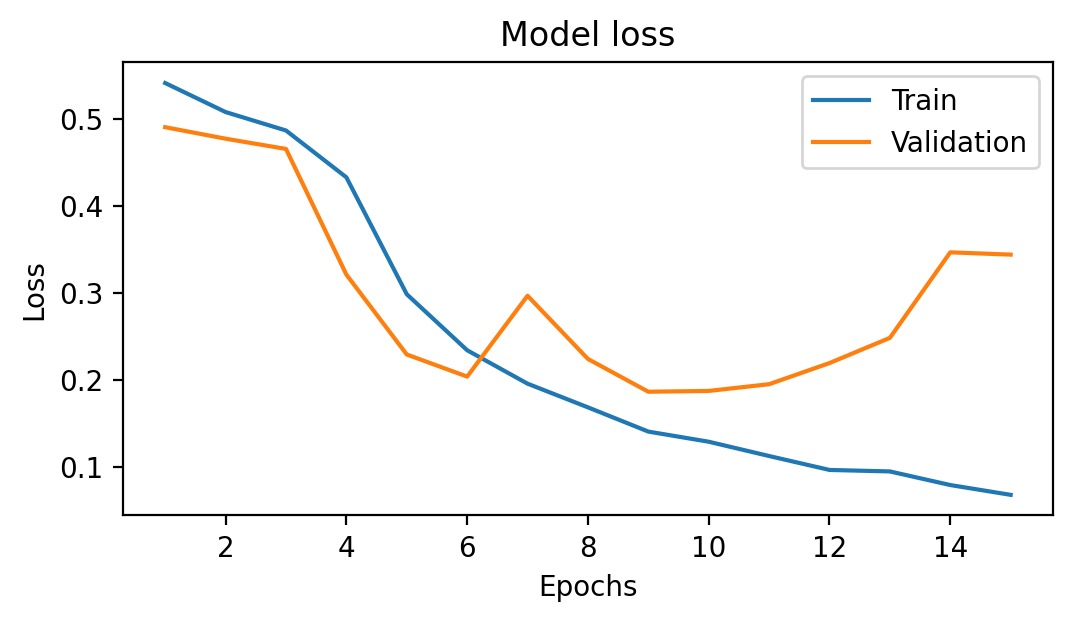

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure(figsize=(6,3), dpi=200)
epoch_count = range(1, len(history_var01_05.history['val_loss']) + 1)
plt.plot(epoch_count, lv_list)
plt.plot(epoch_count, vlv_list)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'])
plt.show()

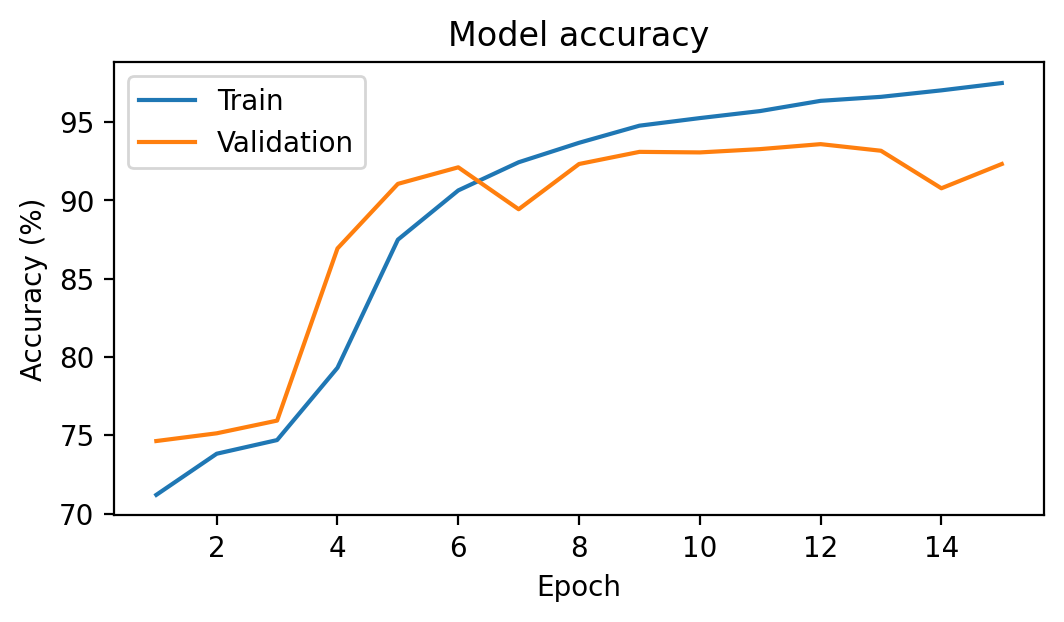

In [ ]:
plt.figure(figsize=(6,3), dpi=200)
epoch_count = range(1, len(history_var01_05.history['val_acc']) + 1)
plt.plot(epoch_count, av_list)
plt.plot(epoch_count, vav_list)
plt.title('Model accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
mdl_ld = load_model("/content/drive/My Drive/model_var01.05.wb.hdf5")

In [ ]:
pred = mdl_ld.predict(x_test_3d)
pred = np.argmax(pred, axis = 1)
lab = np.argmax(ynn_test,axis = 1)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(lab,pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1555
           1       0.92      0.94      0.93      1283

    accuracy                           0.94      2838
   macro avg       0.93      0.94      0.93      2838
weighted avg       0.94      0.94      0.94      2838



Text(0.5, 51.0, 'Predicted Label')

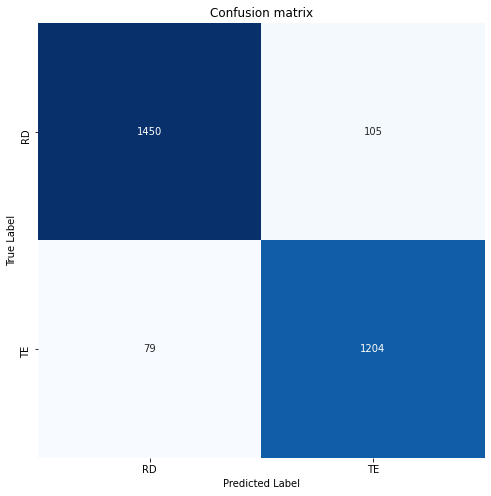

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline

plt.figure(figsize=(8,8))
plt.title("Confusion matrix")

categorias = ['RD','TE']
sns.heatmap(confusion_matrix(lab,pred),
            annot=True,
            fmt='d',
            cmap="Blues",
            cbar=False,
            xticklabels=categorias,
            yticklabels=categorias)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')

Confusion matrix:
 [[1504   50]
 [  87 1078]]


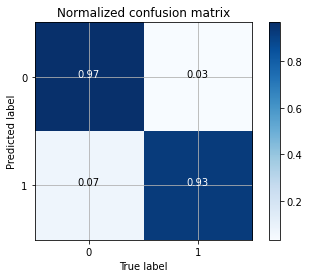

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(np.argmax(ynn_test, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

## Validation tests with external data

TEs validation

In [ ]:
user_frame = fasta_frame('/content/drive/My Drive/fastas/tes_validation.fasta','?')
pad_frame = fasta_frame('/content/drive/My Drive/fastas/pad_ref3.fasta','?')
u_f = [user_frame,pad_frame]
user_df = pd.concat(u_f,ignore_index=True)

# OHE & flat sequences 
user_df_ohe = ohe_fun(user_df)
user_df_flat=flatten_sequence(user_df_ohe)

# Remove pad_ref
user_seq_to_pred = np.delete(user_df_flat, -1, 0)

In [ ]:
predicted_labels_val_05_01 = mdl_ld.predict(np.expand_dims(user_seq_to_pred, axis=2))
print("Modelo 05_01")
print(predicted_labels_val_05_01.argmax(axis=-1))

Modelo 05_01
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]


Human genes

In [ ]:
user_frame_hg = fasta_frame('/content/drive/My Drive/fastas/human_genes.fasta','?')
pad_frame = fasta_frame('/content/drive/My Drive/fastas/pad_ref3.fasta','?')
u_f_hg = [user_frame_hg,pad_frame]
user_df_hg = pd.concat(u_f_hg,ignore_index=True)

# OHE & flat sequences 
user_df_ohe_hg = ohe_fun(user_df_hg)
user_df_flat_hg=flatten_sequence(user_df_ohe_hg)

# Remove pad_ref
user_seq_to_pred_hg = np.delete(user_df_flat_hg, -1, 0)

In [ ]:
predicted_labels_hg_05_01 = mdl_ld.predict(np.expand_dims(user_seq_to_pred_hg, axis=2))
print("Modelo 05_01")
print(predicted_labels_hg_05_01.argmax(axis=-1))

Modelo 05_01
[0 0 0 0 0 0 0 1 0 0 1 0 0 0 0]
